# Load and Preprocess

In [56]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pandas.options.display.max_rows = 999

sns.set_theme(style="whitegrid")
sns.set_palette('colorblind')
# palette = sns.color_palette("colorblind")
palette ={"base": "C3", "optimized": "C2", "modin":"C0"}

df=pandas.read_feather('reports/bench_report_mancorr_11Jul.feather')


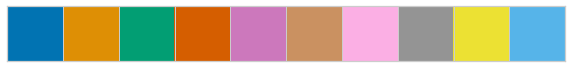

In [57]:
sns.palplot(sns.color_palette("colorblind"))

In [58]:

df['cpu_percent'] = df['cpu_percent'].apply(lambda x: sum(x)/len(x)) 

#TODO factorize scale

# TODO make exitcode = -9 to zeroes
#df.loc[df['oom'] == True, dependent_variables] = 0
#df.head(2)
#df.dtypes

# Sanity Check

In [59]:
df

,bytes_memory,cpu_percent,bytes_sent,bytes_recv,wall_time,exitcode,db_time,rep,wflow,optimizer,process_snapshot
0,1040384,32.500,1468484902,1468484902,62.276851,0,57.619797,1,micro_join.py,base,0
1,8802304,52.650,1468484902,1468484902,62.276851,0,57.619797,1,micro_join.py,base,1
2,19898368,96.875,1468484902,1468484902,62.276851,0,57.619797,1,micro_join.py,base,2
3,30220288,25.000,1468484902,1468484902,62.276851,0,57.619797,1,micro_join.py,base,3
4,44711936,30.950,1468484902,1468484902,62.276851,0,57.619797,1,micro_join.py,base,4
...,...,...,...,...,...,...,...,...,...,...,...
8384,41086976,25.000,13379,13379,1.186456,0,0.880508,1,micro_sel.py,optimized,10
8385,41086976,25.000,13379,13379,1.186456,0,0.880508,1,micro_sel.py,optimized,11
8386,41082880,25.000,13379,13379,1.186456,0,0.880508,1,micro_sel.py,optimized,12
8387,41082880,25.000,13379,13379,1.186456,0,0.880508,1,micro_sel.py,optimized,13


In [60]:
# make sure exitcode is the same in all repetitions
#df.loc[0, 'oom']=True # used to test code below

In [61]:
# def sanity_check():
#     assert (df['bytes_sent'] == df['bytes_recv']).all()
    
#     sub_df = df[factors + ['exitcode']]
#     exitcode_pivot_df = sub_df.pivot(index=set(sub_df.columns)-{'rep','exitcode'}, columns='rep', values='exitcode')
#     col1, restcols = exitcode_pivot_df.columns[0], exitcode_pivot_df.columns[1:]
#     for col in restcols:
#         bitmask = exitcode_pivot_df[col1] == exitcode_pivot_df[col]
#         assert bitmask.all()
# sanity_check()

# Aggregated representation - workflow level

In [62]:
dependent_variables = ['wall_time','bytes_memory', 'cpu_percent', 'bytes_sent', 'bytes_recv', 'exitcode','db_time']
factors = set(df.columns) - set(dependent_variables)
agg_dict = {}
for var in dependent_variables:
    agg_dict[var]='mean'
agg_dict['bytes_memory']='max'
agg = df.groupby(by=list(factors-{'process_snapshot'})).agg(agg_dict)
agg = df.groupby(by=list(factors-{'process_snapshot', 'rep'})).mean()
agg.drop(columns=['process_snapshot', 'rep'], inplace=True)
factors = list(factors - {'process_snapshot', 'rep'})
agg.head(200)

bytes_memory  cpu_percent    bytes_sent  \
wflow         optimizer                                            
micro_join.py base       5.861094e+09    28.022771  1.468485e+09   
              modin      6.274173e+09    38.543781  1.471012e+09   
              optimized  8.217690e+09    28.029926  2.132330e+09   
micro_max.py  base       6.075423e+08    30.256849  1.391039e+08   
              modin      6.292624e+08    27.550556  1.394952e+08   
              optimized  3.811082e+07    63.672500  2.284400e+04   
micro_proj.py base       5.496082e+09    28.194676  1.233530e+09   
              modin      6.670226e+09    31.615140  1.235378e+09   
              optimized  3.288510e+08    30.645652  7.316962e+07   
micro_sel.py  base       5.477347e+09    28.283320  1.233526e+09   
              modin      6.643092e+09    30.481856  1.235303e+09   
              optimized  3.404704e+07    32.771667  1.337900e+04   

                           bytes_recv   wall_time  exitcode     db_time  
wflow         optimizer                                                  
micro_join.py base       1.468485e+09   62.276851       0.0   57.619797  
              modin      1.471012e+09  160.451906       0.0  124.148659  
              optimized  2.132330e+09   91.908522       0.0   90.090591  
micro_max.py  base       1.391039e+08    5.801578       0.0    5.410194  
              modin      1.394952e+08   10.876645       0.0    5.984243  
              optimized  2.284400e+04    0.734470       0.0    0.425034  
micro_proj.py base       1.233530e+09   52.108927       0.0   50.859436  
              modin      1.235378e+09  118.139050       0.0  110.406563  
              optimized  7.316962e+07    3.685909       0.0    3.371961  
micro_sel.py  base       1.233526e+09   51.503656       0.0   50.402863  
              modin      1.235303e+09  116.188401       0.0  109.872643  
              optimized  1.337900e+04    1.186456       0.0    0.880508

# Metric conversion

In [63]:
# convert to MB
agg['bytes_memory']=agg['bytes_memory'].apply(lambda x: x//10**6)
agg['bytes_sent']=agg['bytes_sent'].apply(lambda x: x//10**6)
agg['bytes_recv']=agg['bytes_recv'].apply(lambda x: x//10**6)
agg.rename(columns={'bytes_memory':'mbytes_memory', 'bytes_sent':'mbytes_sent', 'bytes_recv':'mbytes_recv'}, inplace=True)
agg.reset_index(inplace=True)
dependent_variables = list(set(agg.columns) - set(factors))
agg

,wflow,optimizer,mbytes_memory,cpu_percent,mbytes_sent,mbytes_recv,wall_time,exitcode,db_time
0,micro_join.py,base,5861.0,28.022771,1468.0,1468.0,62.276851,0.0,57.619797
1,micro_join.py,modin,6274.0,38.543781,1471.0,1471.0,160.451906,0.0,124.148659
2,micro_join.py,optimized,8217.0,28.029926,2132.0,2132.0,91.908522,0.0,90.090591
3,micro_max.py,base,607.0,30.256849,139.0,139.0,5.801578,0.0,5.410194
4,micro_max.py,modin,629.0,27.550556,139.0,139.0,10.876645,0.0,5.984243
5,micro_max.py,optimized,38.0,63.672500,0.0,0.0,0.734470,0.0,0.425034
6,micro_proj.py,base,5496.0,28.194676,1233.0,1233.0,52.108927,0.0,50.859436
7,micro_proj.py,modin,6670.0,31.615140,1235.0,1235.0,118.139050,0.0,110.406563
8,micro_proj.py,optimized,328.0,30.645652,73.0,73.0,3.685909,0.0,3.371961
9,micro_sel.py,base,5477.0,28.283320,1233.0,1233.0,51.503656,0.0,50.402863


In [64]:
dependent_variables

['cpu_percent',
 'mbytes_sent',
 'wall_time',
 'db_time',
 'mbytes_recv',
 'exitcode',
 'mbytes_memory']

# Network usage

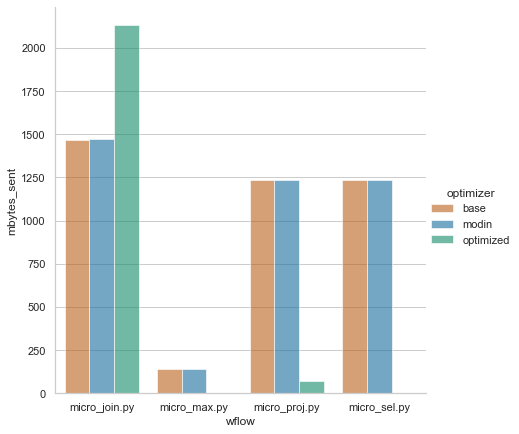

In [67]:
# g = sns.FacetGrid(agg, col="wflow")
# g.map_dataframe(sns.barplot, x="optimizer", y='mbytes_recv')
# #.set_axis_labels("Scale", "Wall time")
# g.add_legend()
g = sns.catplot(
    data=agg, kind="bar",
    x="wflow", y="mbytes_sent", hue="optimizer", palette=palette, alpha=.6, height=6
)

# Max memory consumed

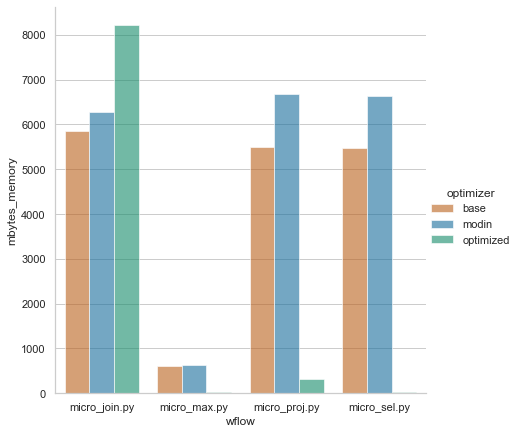

In [66]:
# g = sns.FacetGrid(agg, col="wflow")
# g.map_dataframe(sns.barplot, x="optimizer", y='mbytes_memory')
# #.set_axis_labels("Scale", "Wall time")
# g.add_legend()
g = sns.catplot(
    data=agg, kind="bar",
    x="wflow", y="mbytes_memory", hue="optimizer", palette=palette, alpha=.6, height=6
)

In [40]:
agg.query("wflow=='micro_sel.py' and optimizer=='optimized'")

,wflow,optimizer,mbytes_memory,cpu_percent,mbytes_sent,mbytes_recv,wall_time,exitcode,db_time
11,micro_sel.py,optimized,34.0,32.771667,0.0,0.0,1.186456,0.0,0.880508


# Execution environment ratio

# Calculate Speedup

In [28]:
speedup_factors = list(set(factors)-{'rep'})
df_mean=agg.drop(columns=['rep']).groupby(speedup_factors).mean().reset_index()
df_mean

KeyError: "['rep'] not found in axis"

In [ ]:
#calculate profit
df_diff=df_mean.pivot(index=['scale','net','index','wflow'],columns='ver', values=['wall_time','mem_usage', 'net_usage'])
for var in df_diff.columns.levels[0]:
    df_diff['diff_'+var]=df_diff[var]['pandas']-df_diff[var]['p2d2']
df_diff.head(2)

In [ ]:
df_diff=df_diff.reset_index().drop(['wall_time','mem_usage','net_usage'], axis='columns', level=0)
df_diff=df_diff.droplevel(level=1, axis='columns')
df_diff.head(2)

In [ ]:
# overhead already in df
#df_diff['overhead'] = np.where(df_diff['opt'] == 'excl',
#                                           df_diff['diff_wall_time'] * -1,
#                                           df_diff['diff_wall_time'])

#overhead = df_diff.groupby(['scale','net','index']).agg(
#    {'overhead':np.sum})['overhead']

# Microbenchmarks

In [ ]:
#logarithmic scale TODO
locnoind = agg.query('index==False and net=="loc"')
g = sns.FacetGrid(locnoind, col="wflow")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver', palette=palette)
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

## Operations that ran out of memory:

In [ ]:
locnoind.query('rep==0 and oom==True')[['ver','wflow','scale']].sort_values(by=['ver'])

In [ ]:
os_memory_overhead = 380
vagrant_maxmemory = 25576
vagrant_available = vagrant_maxmemory - os_memory_overhead
g = sns.FacetGrid(locnoind, col="wflow")
g.map_dataframe(sns.barplot, x="scale", y='mem_usage', hue='ver', palette=palette)
g.map(plt.axhline, y=vagrant_available, color='red', label=f'available memory')
g.set_axis_labels("Scale", "Memory Usage")
g.add_legend()

## Question time

- Should I say how I measured the memory usage?
- Is my method for measuring memory usage good enough?
- Is it OK to intentionally let pandas run out of memory (e.g. providing a limited amount of memory), so that the reader sees it's not just about optimizing, but also enabling

In [ ]:
#logarithmic scale TODO
locnoind = df.query('index==True and net=="loc"')
g = sns.FacetGrid(locnoind, col="wflow")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver', palette=palette)
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

In [ ]:
#logarithmic scale TODO
g = sns.FacetGrid(df, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='wall_time', hue='ver')
g.set_axis_labels("Scale", "Wall time")
g.add_legend()

In [ ]:
#speedup (different story)
g = sns.FacetGrid(df_diff, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='diff_wall_time')
g.map(plt.axhline, y=overhead.mean(), color='red', label=f'E(overhead)={overhead.mean():.2f}')
g.set_axis_labels("Scale", "Gain")
plt.legend()

In [ ]:
#add overhead on the x-axis
df_diff_overhead=df_diff[df_diff['scale']=='1'].copy()
df_diff_overhead['scale']='overhead'
df_diff_overhead['diff_wall_time']=overhead.mean()
df_overhead_x = pandas.concat([df_diff, df_diff_overhead])

In [ ]:
#df_overhead_x=df_overhead_x.sort_values(by=['diff_wall_time'])
g = sns.FacetGrid(df_overhead_x, col="net",  row="index")
g.map_dataframe(sns.barplot, x="scale", y='diff_wall_time')
g.set_axis_labels("Scale & Overhead", "Gain")

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
lineplot=sns.lineplot(data=df, x="scale", y="wall_time", hue='vernet', style='index', err_style='bars')

In [ ]:
g = sns.FacetGrid(df, col="net",  row="index")
g.map_dataframe(sns.lineplot, x="scale", y='wall_time', hue='ver')
g.set_axis_labels("Scale", "Wall time")

In [ ]:
#better with the line
g = sns.FacetGrid(df_diff, col="net",  row="index")
g.map_dataframe(sns.lineplot, x="scale", y='diff_wall_time')
g.map(plt.axhline, y=overhead.mean(), color='red', label='overhead')
g.set_axis_labels("Scale", "Wall time")
plt.legend()

In [ ]:

#fig = lineplot.get_figure()
#fig.savefig('all.png') 